I haven't posted anything in a while. Most of my time has been dedicated to school and my latest consultancy. Now that I have a bit of free time, I want to post a few things related to this work experience. Without going into too much detail into the project (due to confidentiality issues), I was tasked with two main jobs:

1. Help to generate a dynamic database using open source Python webscraping libraries  
2. Perform basic NLP on the compiled data. This included NER, topic modelling, and implementing a duplicate detector with LSH

The first job was relatively straightforward, as there are many resources such as this [one](https://realpython.com/python-web-scraping-practical-introduction/) on how to implement a webscraper on Python. The second job was the real challenge, since NLP is an ever [evolving field](https://medium.com/@arie.pratama.s/top-open-sourced-nlp-tools-for-python-faa412aeed86) and it's difficult knowing where to start. 

So, I figured this post could be an opportunity to show off a bit of the skills I acquired these last six months in NLP, **starting with some topic modelling using Latent Dirichlet Allocation!** 

## Part 1: Introduction to topic modelling

What is topic modelling? Suppose we have a large database of news articles related to a general subject, like finance. However, the news articles could be dedicated to different areas of finance. We want to program a simple way to group these articles together by their topics **without** actually reading them. This is basically what topic modelling is. There are different ways to obtain topics from a text. In this case, we will use Latent Dirichlet Allocation (LDA) which ["treats documents as probabilistic distribution sets of words or topics".](https://www.sciencedirect.com/topics/computer-science/latent-dirichlet-allocation) For a given dataset of documents, ["LDA backtracks and tries to figure out what topics would create those documents in the first place".](https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/) This is not meant to be an exhaustive guide, so let's demonstrate how it works with some data. 

The following dataset was scraped from [Reuters](https://www.reuters.com) using the algorithm we developed in my last project. This dataset contains 146 news articles from 2021 related to one keyword: **crypto**. This is an educational post. Feel free to contact me directly if you want the dataset, but it looks like this:

In [136]:
#importing pandas and loading the database:
import pandas as pd
df = pd.read_csv("crypto_sample.csv")

#checking the first news articles of the dataset:
df.head(10)

,ID,Publication Date,Title,Decription,Text,URL
0,0,2021-03-29T08:54:19Z,Exclusive: Visa moves to allow payment settlem...,Visa Inc said on Monday it will allow the use ...,(Reuters) - Visa Inc said on Monday it will al...,https://www.reuters.com/article/us-crypto-curr...
1,1,2021-03-30T09:34:52Z,Exclusive: PayPal launches crypto checkout ser...,PayPal Holdings Inc will announce later on Tue...,LONDON (Reuters) - PayPal Holdings Inc will an...,https://www.reuters.com/article/us-crypto-curr...
2,2,2021-03-14T23:39:06Z,"India to propose cryptocurrency ban, penalisin...",India will propose a law banning cryptocurrenc...,NEW DELHI/MUMBAI (Reuters) - India will propos...,https://www.reuters.com/article/uk-india-crypt...
3,3,2021-04-05T16:36:21Z,Crypto market cap surges to record $2 trillion...,The cryptocurrency market capitalization hit a...,NEW YORK (Reuters) - The cryptocurrency market...,https://www.reuters.com/article/us-crypto-curr...
4,4,2021-03-29T08:45:40Z,EXCLUSIVE-Visa moves to allow payment settleme...,Visa Inc said on Monday it will allow the use ...,March 29 (Reuters) - Visa Inc said on Monday i...,https://www.reuters.com/article/crypto-currenc...
5,5,2021-01-25T22:56:19Z,"Bitcoin, crypto inflows hit record last week: ...",Investment flows into cryptocurrency funds and...,NEW YORK (Reuters) - Investment flows into cry...,https://www.reuters.com/article/us-crypto-curr...
6,6,2021-04-01T13:12:45Z,"As Tesla takes the plunge, wary insurers watch...",If Elon Musk's Tesla wanted to insure all of i...,(Reuters) - If Elon Musk’s Tesla wanted to ins...,https://www.reuters.com/article/us-crypto-curr...
7,7,2021-01-05T14:42:52Z,Crypto trading volumes hit record $68.3 billio...,Trading volumes on major cryptocurrency exchan...,LONDON (Reuters) - Trading volumes on major cr...,https://www.reuters.com/article/us-crypto-curr...
8,8,2021-01-07T15:54:54Z,Crypto market cap surges above $1 trillion for...,The total market value of all cryptocurrencies...,(Reuters) - The total market value of all cryp...,https://www.reuters.com/article/crypto-currenc...
9,9,2021-03-24T09:55:34Z,Crypto firm Blockchain.com raises $300 million...,(This March 24 story corrects second paragraph...,"The exchange rates and logos of Bitcoin (BTH),...",https://www.reuters.com/article/us-crypto-curr...


The database contains the article publication date, title, description and complete text, along wth the URL. In case you were curious if it is really 146 articles long:

In [137]:
len(df)

146

From the first five entries we can see different topics related to cryptocurrencies. **The objective is to group these articles together based on their topic and also see which specific keywords are trending in this news sample.**

## Part 2: Preparing the data for LDA

Before generating the topics through LDA, we will perform some [basic data cleaning](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0). The first step will be to use regular expressions to remove punctuation and transform all text into lower case:

In [138]:
#loading the regular expression library:
import re

#making sure the text column is interpreted as a string:
df['Text']=df['Text'].map(str)

# removing punctuation:
df['text_processed'] = \
df['Text'].map(lambda x: re.sub('[,\.!?]', '', x))

# converting the articles into lower case:
df['text_processed'] = \
df['text_processed'].map(lambda x: x.lower())

#printing the first row of articles:
df['text_processed'].head()

<>:9: DeprecationWarning: invalid escape sequence \.
<>:9: DeprecationWarning: invalid escape sequence \.
<>:9: DeprecationWarning: invalid escape sequence \.
<ipython-input-138-386b7a9ee999>:9: DeprecationWarning: invalid escape sequence \.
  df['Text'].map(lambda x: re.sub('[,\.!?]', '', x))


0    (reuters) - visa inc said on monday it will al...
1    london (reuters) - paypal holdings inc will an...
2    new delhi/mumbai (reuters) - india will propos...
3    new york (reuters) - the cryptocurrency market...
4    march 29 (reuters) - visa inc said on monday i...
Name: text_processed, dtype: object

Now that punctuation and upper cases have been removed from the text, we can proceed to removing stopwords. In order to do this, we can use the stopwords function from the [NLTK library](https://pypi.org/project/nltk/) and a simple prepocess from the [gensim library](https://pypi.org/project/gensim/). I also extended the stopwords function to include terms that are somewhat redundant in this specific search, like crypto, cryptocurrency, etc. 

In [140]:
#importing the required libraries:
import gensim
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import stopwords

#loading English stopwords from NLTK:
stop_words = stopwords.words('english')
#removing specific terms for this search:
stop_words.extend(['last', 'inc', 'year', 'would', 'also', 'reuters', 'cryptocurrency',
                  'said', 'digital', 'currency', 'crypto', 'asset', 'assets', 'new'])

#defining a function for sentences + 
#removing punctuation with the deacc arg:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

#defining the function to remove stopwords:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

#making the new df to apply these functions:
data = df.text_processed.values.tolist()
data_words = list(sent_to_words(data))

#removing stop words:
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['visa', 'monday', 'allow', 'use', 'usd', 'coin', 'settle', 'transactions', 'payment', 'network', 'latest', 'sign', 'growing', 'acceptance', 'currencies', 'mainstream', 'financial', 'industry', 'company', 'told', 'launched', 'pilot', 'program', 'payment', 'platform', 'cryptocom', 'plans', 'offer', 'option', 'partners']


## Part 3: Building the LDA model with Gensim

Now that we have cleaned up the text data, we can proceed to [building our LDA model](https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21) using the Gensim library. The first step is to create a dictionary from our data. Then we will use a function from Gensim to convert this dictionary into a bag of words corpus. Both of these elements can be saved in case we want to introduce new articles in the future:

In [141]:
#importing the corpora function:
import gensim.corpora as corpora

#creating the dictionary from our data:
id2word = corpora.Dictionary(data_words)

#creating the corpus:
texts = data_words

#identifying the Term Document Frequency:
corpus = [id2word.doc2bow(text) for text in texts]

#saving the corpus
import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
id2word.save('crypto_news_dictionary.gensim')

The next step is to create the LDA model. There are different specs that can be adjusted in the model. However, arguably the most important configuration is the number of topics we want to find. Since we do not *a priori* how many topics we can expect to find in these financial news articles, we can choose 5 to start and see what the model does:

In [143]:
#building the LDA model:
ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)


#saving this model:
ldamodel.save('model_crypto.gensim')

#printing the first five words for each topic:
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.012*"us" + 0.009*"sec" + 0.008*"securities" + 0.007*"irs" + 0.006*"circle"')
(1, '0.035*"bitcoin" + 0.016*"market" + 0.013*"billion" + 0.012*"investors" + 0.009*"trading"')
(2, '0.033*"bitcoin" + 0.015*"company" + 0.013*"tesla" + 0.010*"companies" + 0.007*"use"')
(3, '0.012*"quarter" + 0.011*"billion" + 0.008*"management" + 0.008*"rose" + 0.007*"musk"')
(4, '0.009*"regulatory" + 0.009*"bank" + 0.008*"government" + 0.006*"india" + 0.006*"mining"')


The output above shows the five topics and their key terms. Each key term has an associated weight next to it. The first topic deals with regulation in the U.S. while the second appears to deal more with the BTC market outlook. In the final section we will zoom into each topic to highlight these differences. For now, let's determine which topics are most prevalent in each article. Thanks to this [great post](https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/) for providing nice output code:

In [144]:
#defining a sentence function:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    #init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=corpus, texts=data_words)

#Format:
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.9204,"bitcoin, company, tesla, companies, use, value...","[visa, monday, allow, use, usd, coin, settle, ..."
1,1,2.0,0.9960,"bitcoin, company, tesla, companies, use, value...","[london, paypal, holdings, announce, later, tu..."
2,2,4.0,0.7369,"regulatory, bank, government, india, mining, c...","[delhi, mumbai, india, propose, law, banning, ..."
3,3,1.0,0.9957,"bitcoin, market, billion, investors, trading, ...","[york, market, capitalization, hit, time, peak..."
4,4,2.0,0.9952,"bitcoin, company, tesla, companies, use, value...","[march, visa, monday, allow, use, usd, coin, s..."
5,5,3.0,0.8511,"quarter, billion, management, rose, musk, bitc...","[york, investment, flows, funds, products, hit..."
6,6,4.0,0.5303,"regulatory, bank, government, india, mining, c...","[elon, musk, tesla, wanted, insure, recent, bi..."
7,7,1.0,0.9936,"bitcoin, market, billion, investors, trading, ...","[london, trading, volumes, major, exchanges, h..."
8,8,1.0,0.4639,"bitcoin, market, billion, investors, trading, ...","[total, market, value, rose, trillion, first, ..."
9,9,1.0,0.8731,"bitcoin, market, billion, investors, trading, ...","[exchange, rates, logos, bitcoin, bth, ether, ..."


The dominant topic column represents which topic each article belongs to. The topic percentage contribution meanwhile, is an estimation of the goodness of fit for each topic. For example, the first article on the list is dominated in 98% by topic 2, which has keyterms: *bitcoin, company, tesla, companies, use*, etc. This table can be easily exported to Excel using pandas. For now, we will proceed to performing some topic modelling visualizations and inspecting the topics more closely...

## Part 4: Topic Modelling Visualizations

So far, we have identified the topics in our crypto news dataset. We were also able to see which topic dominates each specific news article. The next step is to dive into how to visualize the topics and how they relate with each other. The first plot will be a bit complex and will show how the word counts are distributed by each topic. This will illustrate if specific topics contain lengthier word counts than others. We will work with a four topic model from now on, just to have symmetric plots:

In [145]:
## Redoing the model and output with only 4 topics:
NUM_TOPICS = 4

#importing the LDA model:
# Build LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

#saving this model:
ldamodel.save('model4_bitcoin.gensim')

#printing the first five words for each topic:
topics = ldamodel.print_topics(num_words=5)

def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=corpus, texts=data_words)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

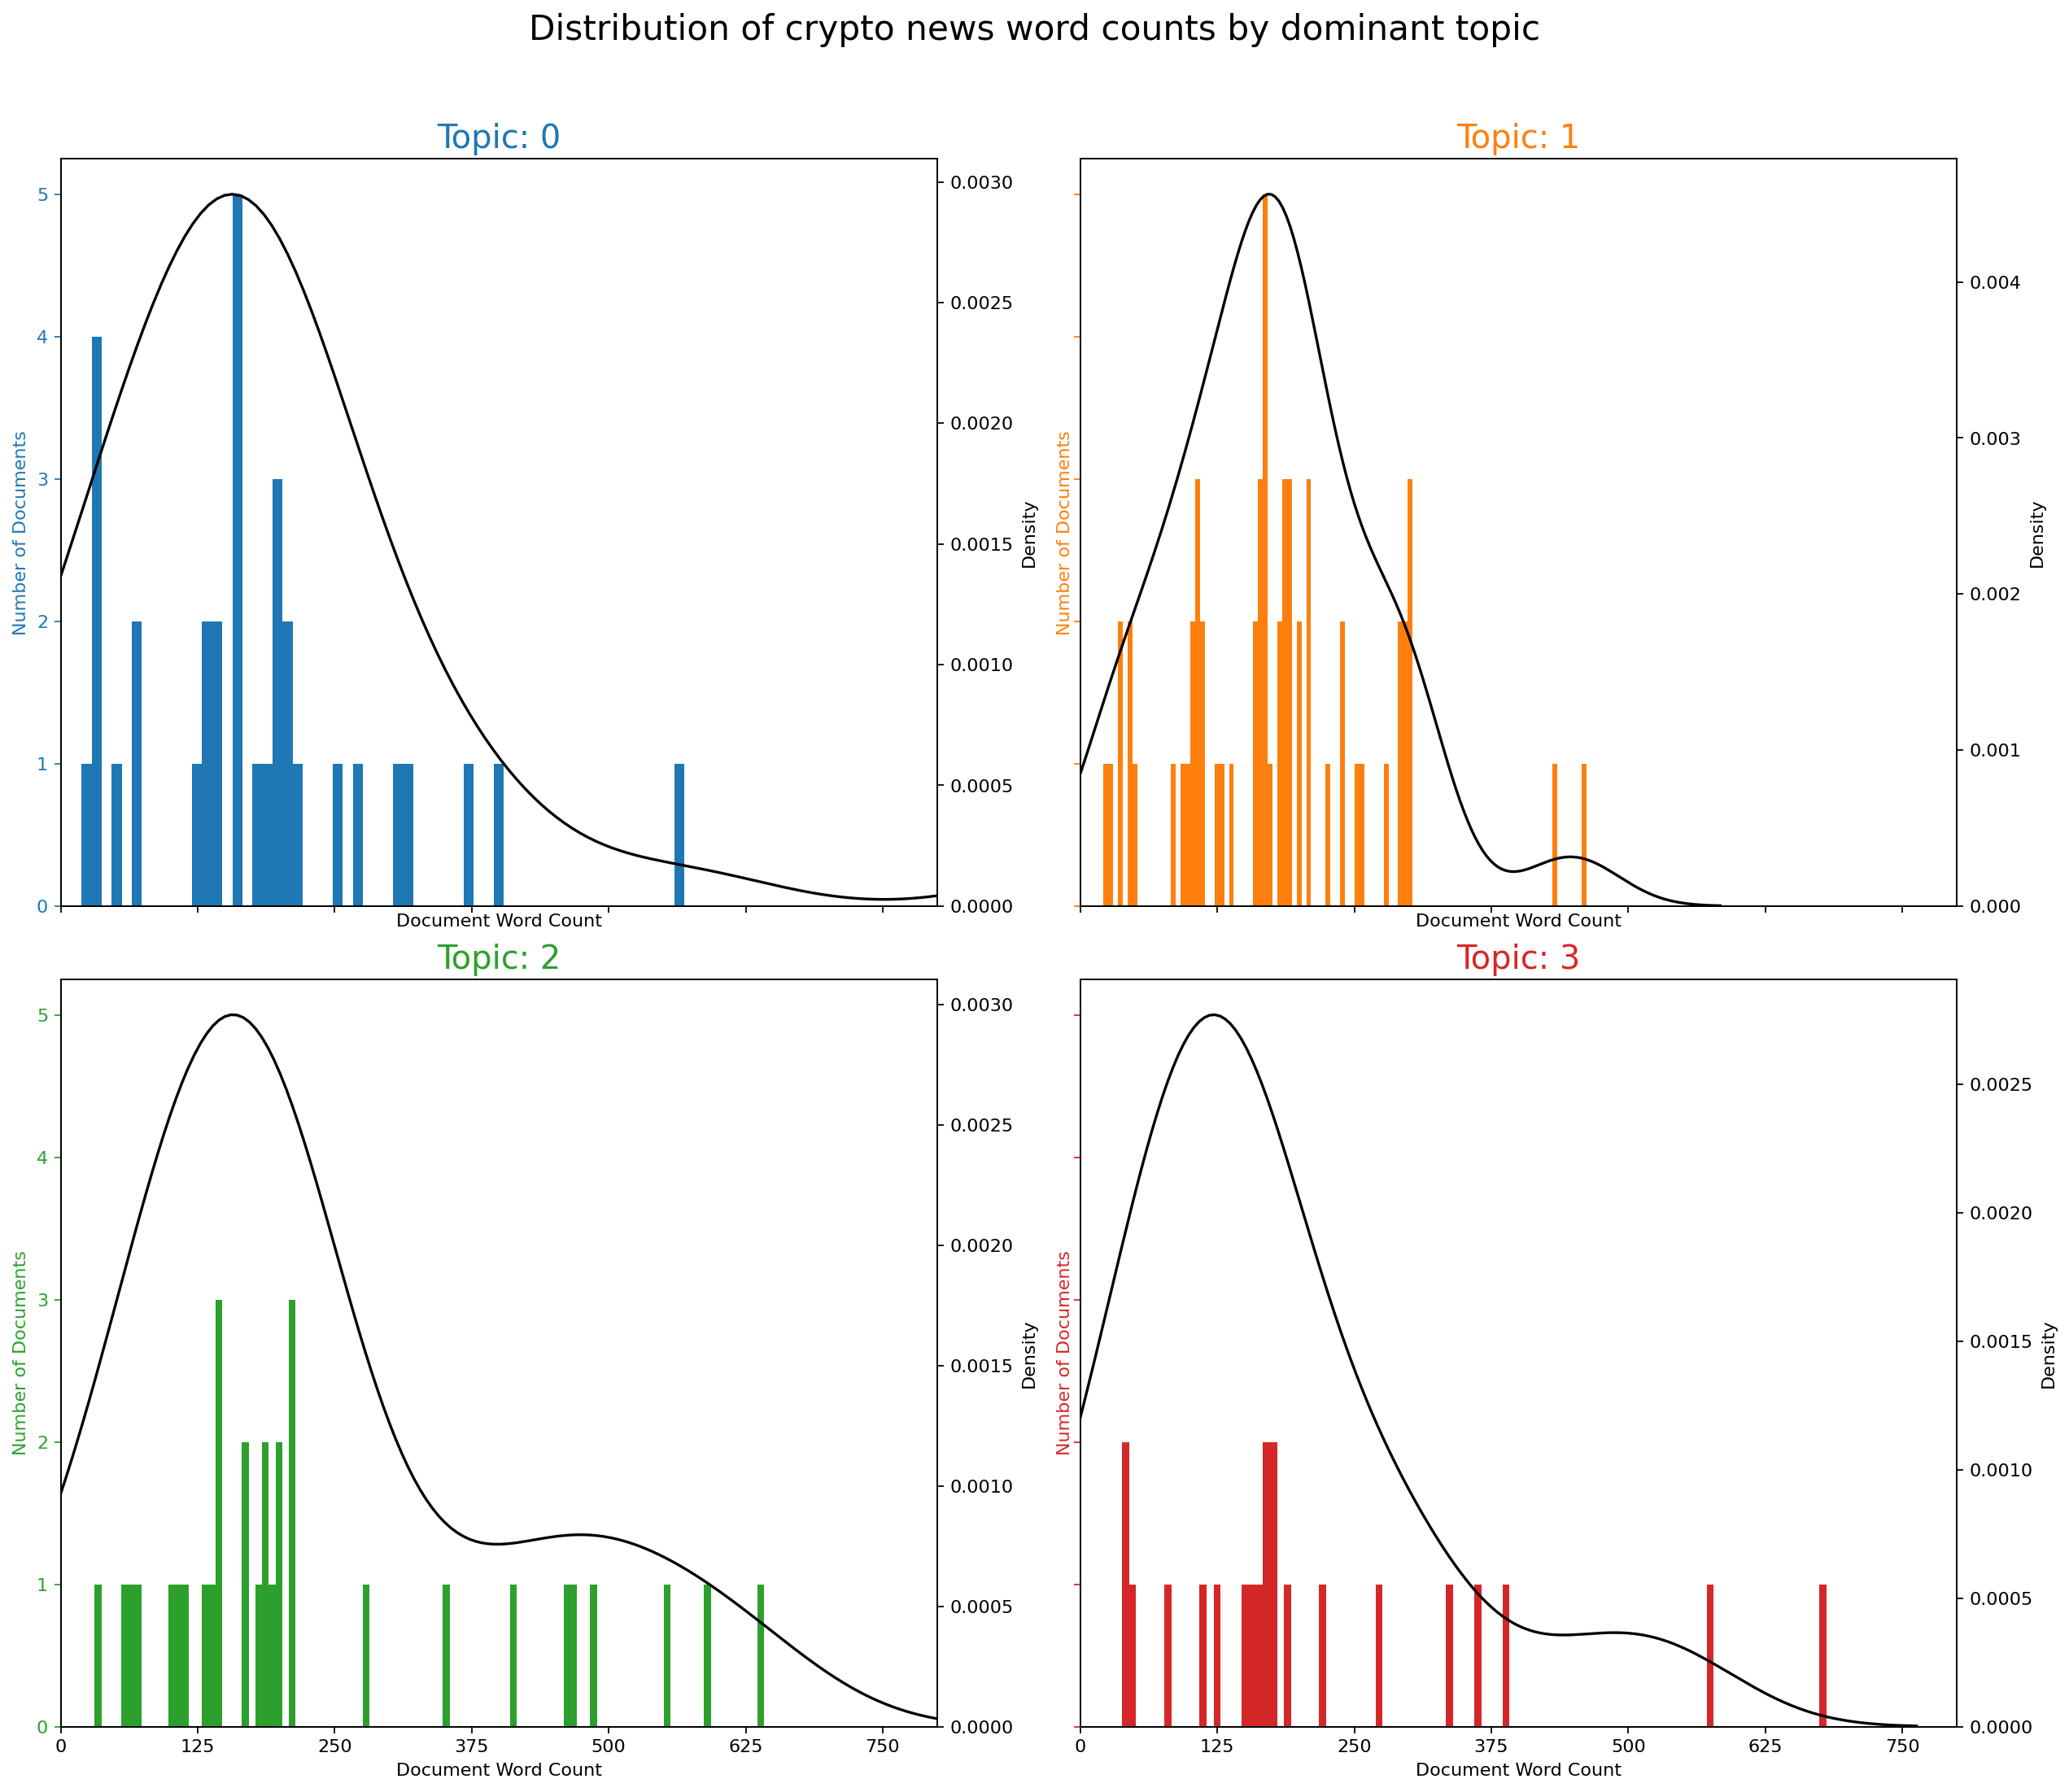

In [146]:
#importing matplotlib:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 100, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 800), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=18, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of crypto news word counts by dominant topic', fontsize=19)
plt.savefig('post9_p1.png', dpi=300, bbox_inches='tight')
plt.show()

The figure above has a lot of information. In general we can conclude that each topic has a different distribution. For example, topic 0 and 3 are skewed to the left, meaning shorter word counts. Topic 2 appears to have the heaviest tailed distribution, while Topic 1 has the shortest tail. Next, we will plot the word counts for the keywords found in each topic:

C:\Users\r_jun\miniconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\r_jun\miniconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\r_jun\miniconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\r_jun\miniconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator


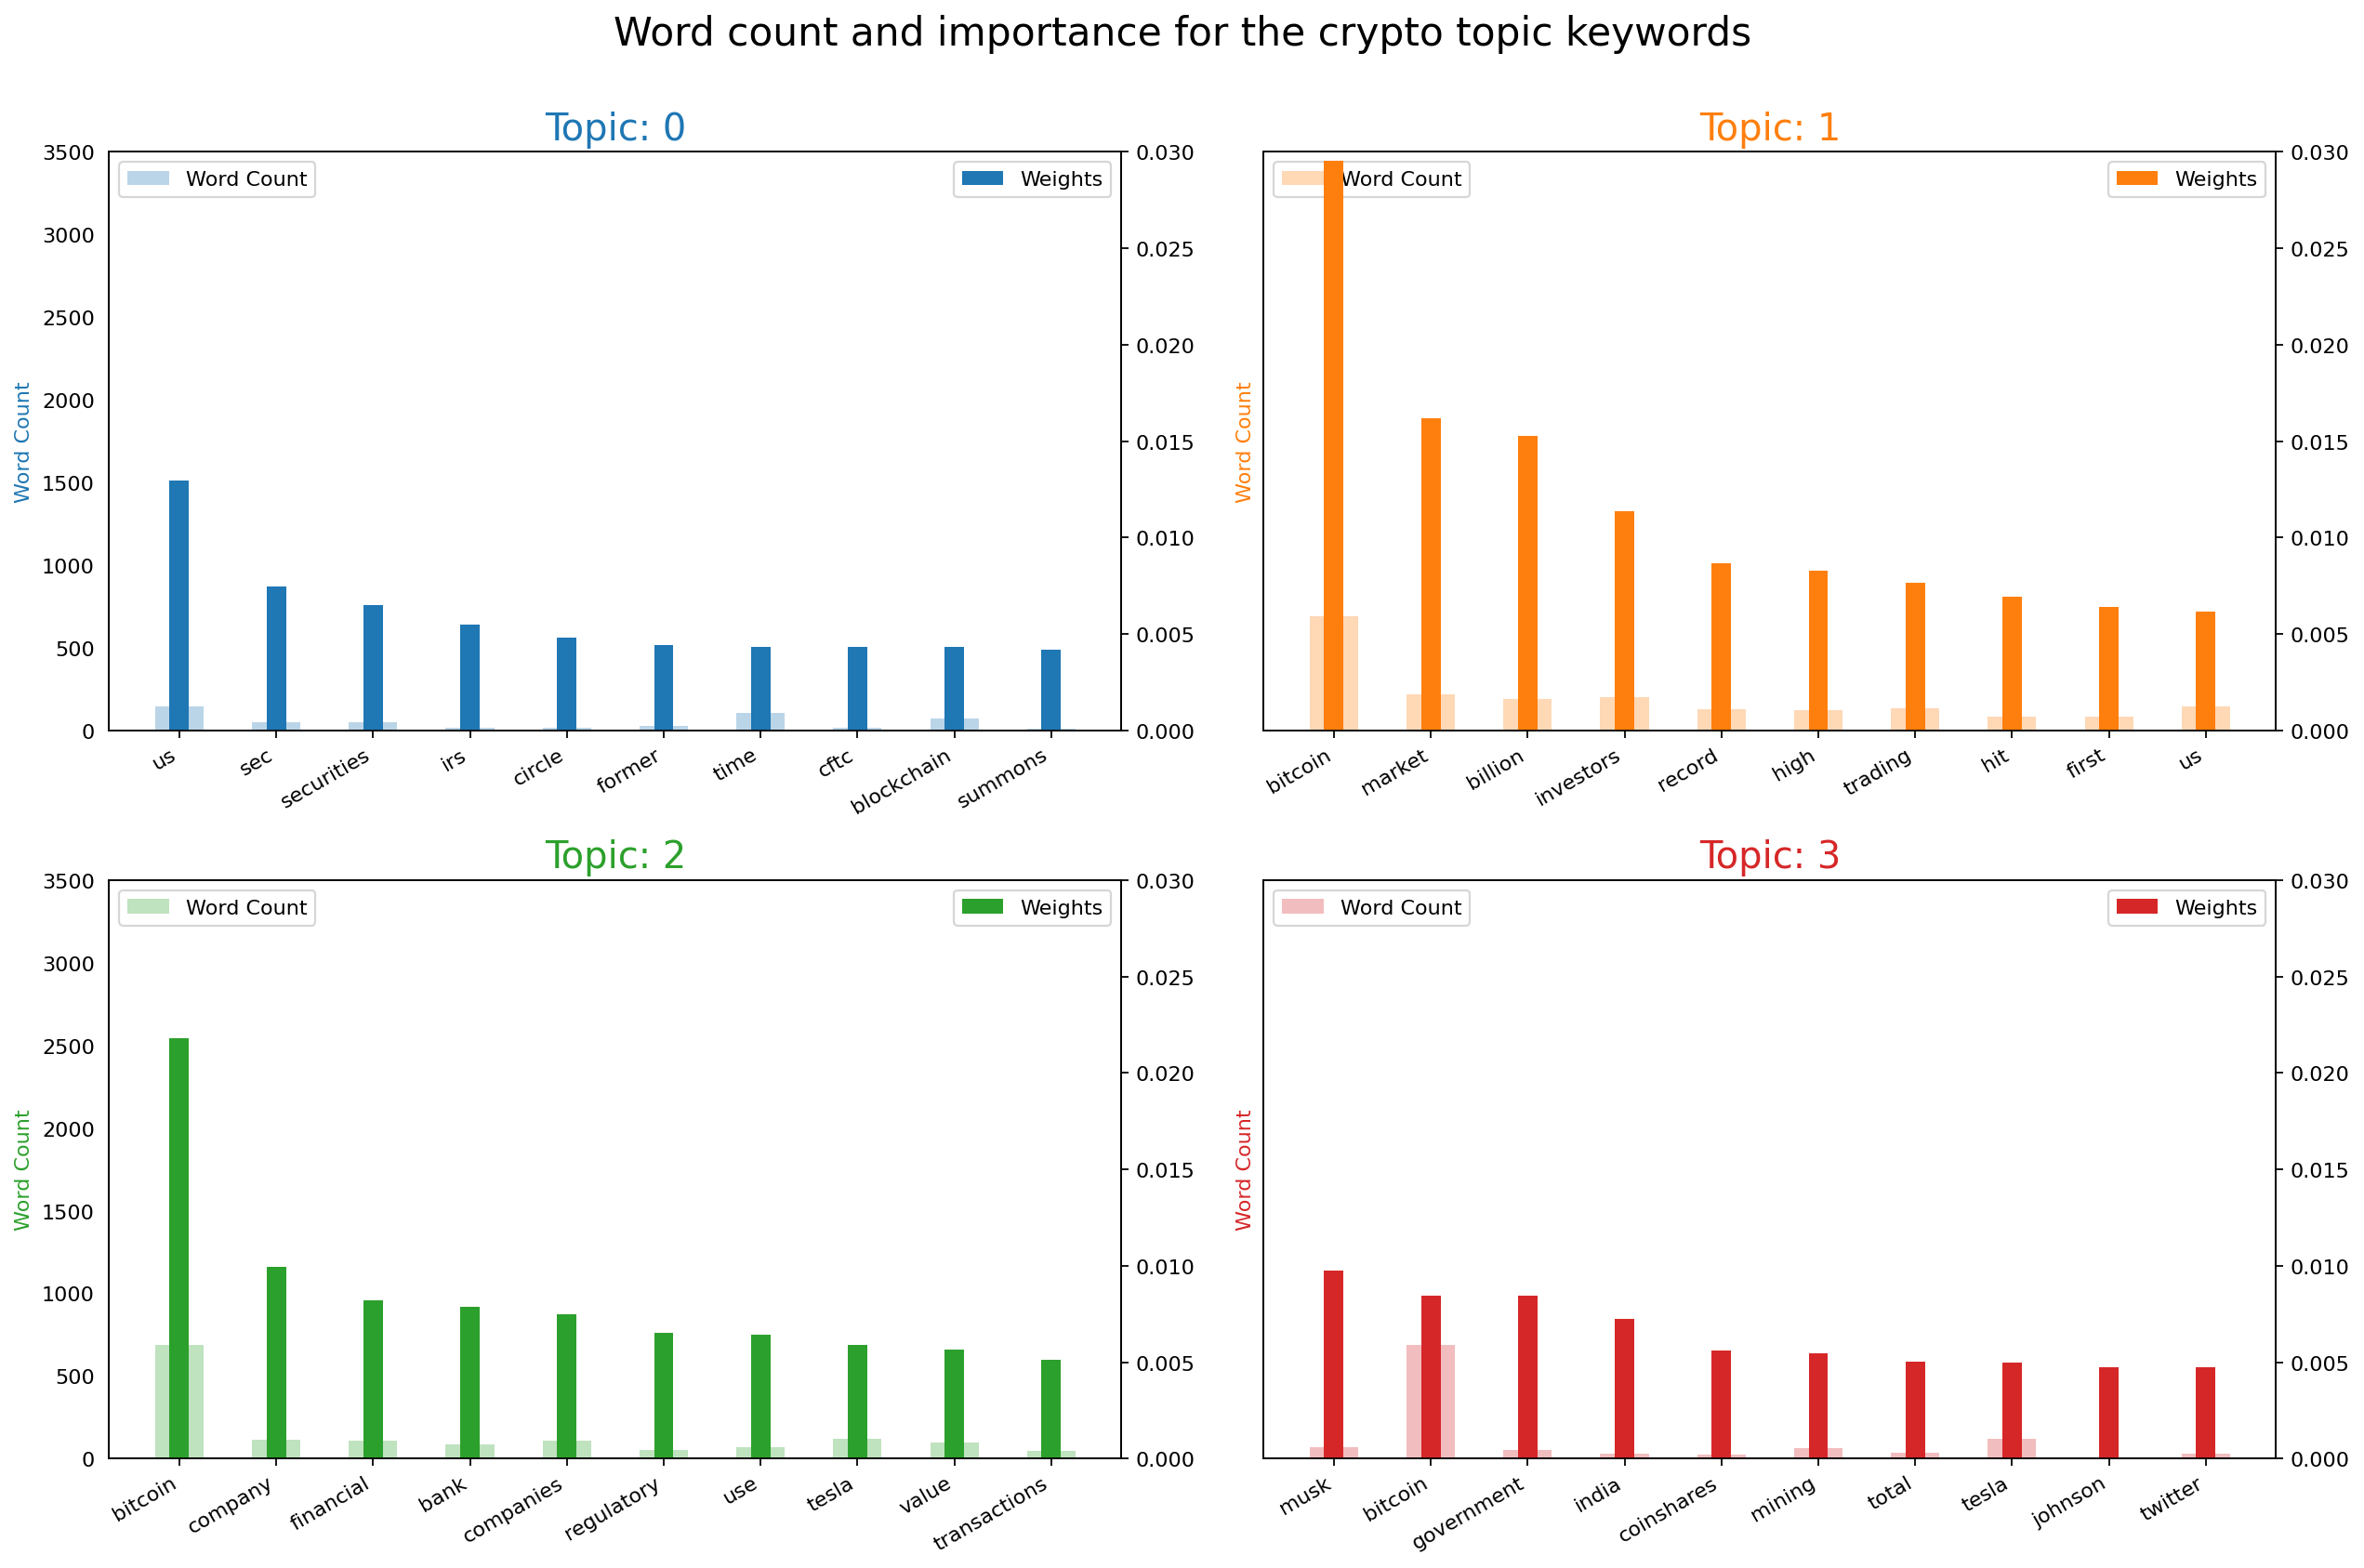

In [147]:
from collections import Counter
topics = ldamodel.show_topics(formatted=False)
data_flat = [w for w_list in data_words for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=18)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word count and importance for the crypto topic keywords', fontsize=19, y=1.05)    
plt.savefig('post9_p2.png', dpi=300, bbox_inches='tight')

plt.show()

Now we can truly appreciate the differences in each topic:

1. Topic 0 includes articles related to regulation in the US, as entities like the SEC and IRS are included 
2. Topic 1 is all about the market performance of Bitcoin, as it includes its valuation and terms like "high" and "hit"
3. Topic 2 is also about BTC, but has news related to other firms, inluding Tesla
4. Topic 3 includes a bit of everything, as it has terms like Musk, India, Mining, etc. This topic is probably an umbrella for news articles not included in the first three topics. 


It's amazing how we have been able to detect such distinct topics for a relatively small database from one news source! Lastly, we can visualize how these topics relate to each other using the [t-distributed Stochastic Neighbor Embedding](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). In essence, this technique converts similarities between data points to joint probabilities, in order to perform topic clustering. 

In [148]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(ldamodel[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
plt.savefig('post9_p3.png', dpi=300, bbox_inches='tight')
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 143 samples in 0.001s...
[t-SNE] Computed neighbors for 143 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 143 / 143
[t-SNE] Mean sigma: 0.182201
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.550850
[t-SNE] KL divergence after 900 iterations: 0.153726


Loading BokehJS ...

<Figure size 432x288 with 0 Axes>

The figure shows how the fourth topic (shown in red) does not relate to the other topics. Topic 0, shown in blue, is the most frequent topic and has slight overlap with Topic 1. There are even more advanced visualization techniques but this is good enough for now!

## Conclusions

I'm still new to all of this. It's amazing how useful LDA can be, even when applied to a relatively homogeneous news database related to cryptocurrencies!